In [1]:
# Input:
path_data = '../../01 data/train_pollution.csv'
n_lag = 3
n_out = 2

path_01 = '../../03 outputs/multi-step/01/'
path_scaler = path_01 + 'time_scaler.pickle'
path_x_train = path_01 + 'X_train.npy'
path_y_train = path_01 + 'y_train.npy'
path_x_val = path_01 + 'X_val.npy'
path_y_val = path_01 + 'y_val.npy'
path_x_test = path_01 + 'X_test.npy'
path_y_test = path_01 + 'y_test.npy'

path_02 = '../../03 outputs/multi-step/02/'
path_forecaster_vector = path_02 + 'forecaster_vector.hdf5'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import pickle
from keras.models import load_model

In [23]:
# Convert to datetime
def date_parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Load data
data = pd.read_csv(path_data)
data['date_time'] = data['date_time'].apply(date_parser)
data = data[
    ['target_carbon_monoxide', 'sensor_1', 'sensor_2', 'sensor_5', 'target_benzene', 'target_nitrogen_oxides']
]
print(data.shape)
data.head(3)

(7111, 6)


,target_carbon_monoxide,sensor_1,sensor_2,sensor_5,target_benzene,target_nitrogen_oxides
0,2.5,1387.2,1087.8,1293.4,12.0,167.7
1,2.1,1279.1,888.2,1010.9,9.9,98.9
2,2.2,1331.9,929.6,1117.0,9.2,127.1


In [4]:
# Load data (lag 3 steps)
X_train = np.load(open(path_x_train, 'rb'))
y_train = np.load(open(path_y_train, 'rb'))
X_val = np.load(open(path_x_val, 'rb'))
y_val = np.load(open(path_y_val, 'rb'))
X_test = np.load(open(path_x_test, 'rb'))
y_test = np.load(open(path_y_test, 'rb'))

In [5]:
# Load model and tokenizer
scaler = pickle.load(open(path_scaler, 'rb'))

forecaster_vector = load_model(path_forecaster_vector)


In [6]:
def invert_transform_pred(pred, X_):
    # Invert the prediction scaling
    n_features = X_.shape[2]
    inv_X = X_.reshape((X_.shape[0], X_.shape[1] * X_.shape[2]))
    inv_X = np.concatenate((pred, inv_X[:, -n_features+1:]), axis=1)
    inv_X = scaler.inverse_transform(inv_X)
    inv_pred = inv_X[:,0]

    return inv_pred

# Vector output

In [17]:
# Forecast train
pred_train_vector = forecaster_vector.predict(X_train, verbose=0)
pred_train_vector_0 = invert_transform_pred(pred_train_vector[:,0].reshape(-1,1), X_train)
pred_train_vector_1 = invert_transform_pred(pred_train_vector[:,1].reshape(-1,1), X_train)
pred_train_vector = pd.DataFrame({'prediction (t)': pred_train_vector_0, 'prediction (t+1)': pred_train_vector_1})

# Forecast val
pred_val_vector = forecaster_vector.predict(X_val, verbose=0)
pred_val_vector_0 = invert_transform_pred(pred_val_vector[:,0].reshape(-1,1), X_val)
pred_val_vector_1 = invert_transform_pred(pred_val_vector[:,1].reshape(-1,1), X_val)
pred_val_vector = pd.DataFrame({'prediction (t)': pred_val_vector_0, 'prediction (t+1)': pred_val_vector_1})

# Forecast test
pred_test_vector = forecaster_vector.predict(X_test, verbose=0)
pred_test_vector_0 = invert_transform_pred(pred_test_vector[:,0].reshape(-1,1), X_test)
pred_test_vector_1 = invert_transform_pred(pred_test_vector[:,1].reshape(-1,1), X_test)
pred_test_vector = pd.DataFrame({'prediction (t)': pred_test_vector_0, 'prediction (t+1)': pred_test_vector_1})

In [26]:
# Combine predictions
pred_train_vector['split'] = 'train'
pred_val_vector['split'] = 'val'
pred_test_vector['split'] = 'test'

pred_vector = pd.concat([pred_train_vector, pred_val_vector, pred_test_vector], axis=0).reset_index(drop=True)
pred_vector.index = pred_vector.index + n_lag

# Combine with original data
pred_vector = pd.concat([data['target_carbon_monoxide'], pred_vector], axis=1)
pred_vector['target_carbon_monoxide (t+1)'] = pred_vector['target_carbon_monoxide'].shift(1)
pred_vector = pred_vector[['target_carbon_monoxide', 'target_carbon_monoxide (t+1)', 'prediction (t)', 'prediction (t+1)', 'split']]
print(pred_vector.shape)
pred_vector.head(8)

(7111, 5)


,target_carbon_monoxide,target_carbon_monoxide (t+1),prediction (t),prediction (t+1),split
0,2.5,NaN,NaN,NaN,NaN
1,2.1,2.5,NaN,NaN,NaN
2,2.2,2.1,NaN,NaN,NaN
3,2.2,2.2,2.302422,2.213876,train
4,1.5,2.2,2.333853,2.224948,train
5,1.2,1.5,2.025875,1.970880,train
6,1.2,1.2,1.613261,1.633437,train
7,1.0,1.2,1.491561,1.515619,train


In [27]:
# Check the split boundary
train_split = pred_vector[pred_vector['split']=='train'].index[-1]
val_split = pred_vector[pred_vector['split']=='val'].index[-1]
print(train_split, val_split)

4622 5689


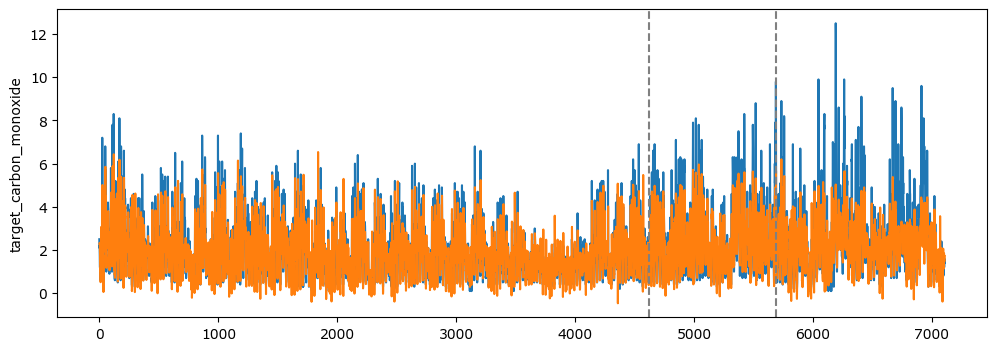

In [29]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred_vector, x=pred_vector.index, y='target_carbon_monoxide')
sns.lineplot(pred_vector, x=pred_vector.index, y='prediction (t)')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

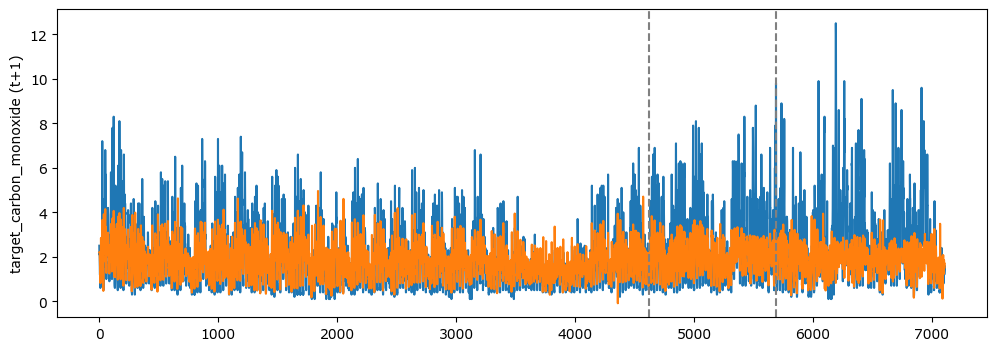

In [30]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred_vector, x=pred_vector.index, y='target_carbon_monoxide (t+1)')
sns.lineplot(pred_vector, x=pred_vector.index, y='prediction (t+1)')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

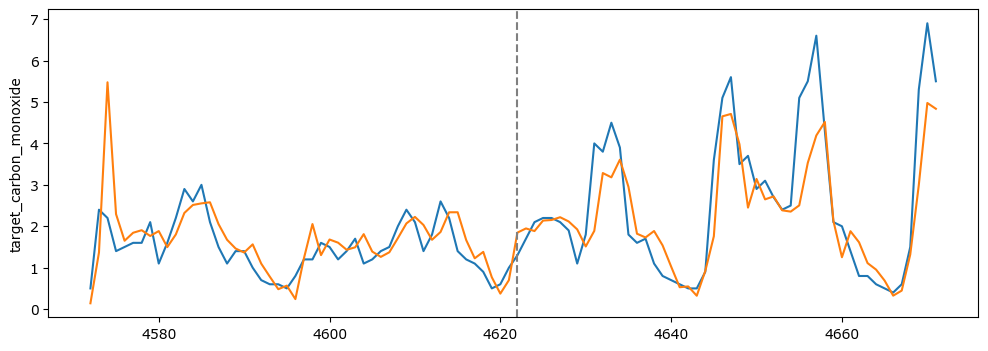

In [39]:
# Plot partial
plt.figure(figsize=(12,4))
sns.lineplot(pred_vector.iloc[train_split-50:train_split+50,:], x=pred_vector.iloc[train_split-50:train_split+50,:].index, y='target_carbon_monoxide')
sns.lineplot(pred_vector.iloc[train_split-50:train_split+50,:], x=pred_vector.iloc[train_split-50:train_split+50,:].index, y='prediction (t)')
plt.axvline(train_split, linestyle='--', color='grey')
plt.show()

In [33]:
# Accuracy
print('first step')
mae_train = round(mean_absolute_error(pred_vector.loc[pred_vector['split']=='train', 'target_carbon_monoxide'], pred_vector.loc[pred_vector['split']=='train', 'prediction (t)']), 4)
mae_val = round(mean_absolute_error(pred_vector.loc[pred_vector['split']=='val', 'target_carbon_monoxide'], pred_vector.loc[pred_vector['split']=='val', 'prediction (t)']), 4)
mae_test = round(mean_absolute_error(pred_vector.loc[pred_vector['split']=='test', 'target_carbon_monoxide'], pred_vector.loc[pred_vector['split']=='test', 'prediction (t)']), 4)
print(f'training MAE: {mae_train}')
print(f'validation MAE: {mae_val}')
print(f'testing MAE: {mae_test}')
print(f'std: ' + str(round(pred_vector[pred_vector['split']=='train'][f'target_carbon_monoxide'].std(),3)))
print('')
print('second step')
mae_train = round(mean_absolute_error(pred_vector.loc[pred_vector['split']=='train', 'target_carbon_monoxide (t+1)'], pred_vector.loc[pred_vector['split']=='train', 'prediction (t+1)']), 4)
mae_val = round(mean_absolute_error(pred_vector.loc[pred_vector['split']=='val', 'target_carbon_monoxide (t+1)'], pred_vector.loc[pred_vector['split']=='val', 'prediction (t+1)']), 4)
mae_test = round(mean_absolute_error(pred_vector.loc[pred_vector['split']=='test', 'target_carbon_monoxide (t+1)'], pred_vector.loc[pred_vector['split']=='test', 'prediction (t+1)']), 4)
print(f'training MAE: {mae_train}')
print(f'validation MAE: {mae_val}')
print(f'testing MAE: {mae_test}')
print(f'std: ' + str(round(pred_vector[pred_vector['split']=='train'][f'target_carbon_monoxide (t+1)'].std(),3)))

first step
training MAE: 0.4727
validation MAE: 0.6185
testing MAE: 0.7735
std: 1.192

second step
training MAE: 0.5055
validation MAE: 0.8401
testing MAE: 1.069
std: 1.192


In [34]:
# Save
pred_vector.to_csv('../../03 outputs/multi-step/03/prediction_vector.csv')